# Algorithms for computing the Fréchet distance
### _By Casper Siksma and Dennis Arets

## Introduction
Welcome to this educational notebook on the Fréchet distance, a popular measure of curve similarity. Firstly, this notebook will try to explain the concept of the Fréchet distance using an illustrative example and subsequently present its formal definition. Secondly, it will address several approaches to solve Fréchet distance problems based on existing literature. These approaches will be presented in the form of algorithms, their implementation and a visualizaiton. Some of the visualizations will be interactive and we encourage readers to leverage this to increase their understanding. The notebook is expected to be read from top to bottom and having some background in mathematics or computer science is recommended.

## What is the Fréchet distance?
The Fréchet distance, named after French mathematician Maurice Fréchet, is a measure of similarity between curves. Intuitively, it is used to answer the question: "how much do two given curves resemble each other?" [1]. Given that the problem of curve similarity exists in various domains, the Fréchet distance is a popular metric used in many applications ranging from the analysis and visualization of movement data to speech recognition [2, 3]. Compared to other metrics such as the Hausdorff distance, the Fréchet distance is considered to be of high quality since it accounts for the order of the vertices in a curve. 

### Intuitive Definition
Before we formalize the definition of the Fréchet distance, let us introduce the concept using the following example: A man is walking his dog on a leash. The man traverses the finite path corresponding to a given curve (black), and the dog traverses the finite path corresponding to another cruve (red). Intuitively, the leash represents the distance between the man and the dog (green). Both the man and the dog can control their speed, but neither are allowed to move backwards. The Fréchet distance of the curves is then given by the minimum length of the leash necessary for both the man and the dog to fully traverse their paths from start to finish.

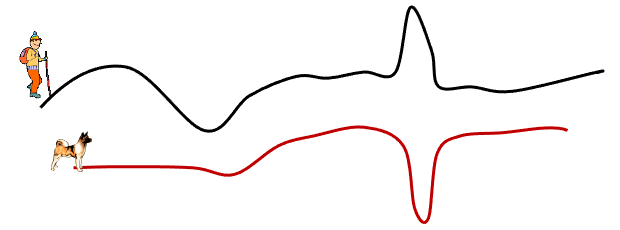

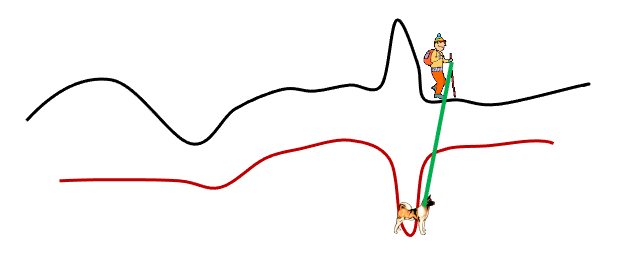




### Formal Definition
Formally, we can define the Fréchet distance as follows. Let $V$ denote an arbitrary Euclidean vector space. We define a curve as a continuous mapping $f : [a, b] \rightarrow V$ with $a, b \in \mathbb{R}$ and $a < b$. Thereby, let $P$ and $Q$ be curves defined as $P : [a, a'] \rightarrow V$ and $Q : [b, b'] \rightarrow V$ respectively. In addition, let $\alpha$ and $\beta$ be reparameterizations defined as continuous, increasing, surjections $\alpha : [0,1] \rightarrow [0,1]$ and $\beta : [0,1] \rightarrow [0,1]$. Then, $\delta_F(P,Q)$ denotes their Fréchet distances which is defined as:
$$
\begin{equation}
\delta_F(P,Q) = \inf_{\alpha, \beta} \max_{t \in [0,1]}\left\lVert P(\alpha(t)) - Q(\beta(t)) \right\rVert
\end{equation}
$$
Perhaps useful is considering parameter $t$ as 'time', where $ P(\alpha(t))$ denotes the position of the man on the curve at time $t$ and $Q(\beta(t))$ denotes the position of the dog on the curve at time $t$ or vice versa.

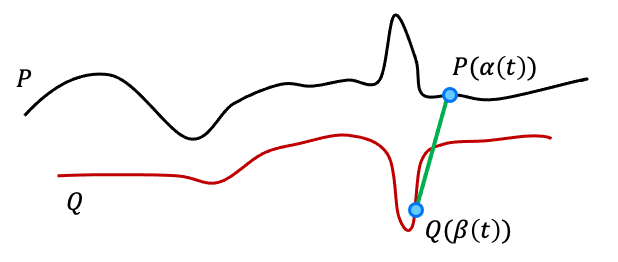

### Related Problems

Based on these definitions, the Fréchet distance could be considered from two different viewpoints. Firstly, as mentioned previously, one could ask what is the minimum length of the leash necessary for both the man and the dog to fully traverse their paths from start to finish, i.e determine $\delta_F$. This is also refererd to as the minimization problem. Alternatively, given a leash of length $\epsilon$, one could ask if the leash is long enough for the man and dog to complete their paths from start to finish, i.e. determine if $\delta_F \leq \epsilon$. This is referred to as the decision problem and is easier to compute than the minimizaition problem.

## Polygonal Curves
The current state of the literature is mainly concerned with polygonal curves, which can be used to approximate arbitrary curves. Hence, we will focus only on polygonal curves for the remainder of this notebook. A polygonal curve is a connected series of line segments that is specified by a sequence of points, also called vertices. Two examples of such curves could look as follows:

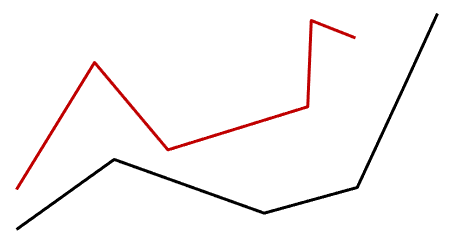

More formally, a polygonal curve is a mapping $P: [0, n] \rightarrow V$ with $n \in \mathbb{N}$  which is specifed by a sequence of vertices $(P_1, P_2, \dots, P_n)$ where $n$ is called the length of $P$. To use polygonal curves in algorithms that compute or approximate the Fréchet distance, we first implement a custom data structure for polygonal curves in the form of a `PolyCurve` class. Note that for demonstrative purposes we will only consider curves in 2-dimensional space, even though the previous definitions and the Fréchet distance work for polygonal curves in arbitrary dimensions. Consequently, an instance of the `PolyCurve` class is defined by a list of tuples that contain an $x$ and $y$ coordinate.

The following code blocks define the imports, constants and `PolyCurve` class in order.

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import functools
from sympy import N, Segment, Point, Circle
import sympy
from ipywidgets import interactive, RadioButtons
import itertools as it
from typing import Tuple
from matplotlib.colors import ListedColormap

GRID_GRANULARITY = 100
COLOR_RED='#c00000'
COLOR_BLACK='#000000'
COLOR_GREEN='#009933'
COLOR_GRAY='#999999'
COLOR_BLUE='#0075f6'

In [ ]:
class PolyCurve:
  """
  Curve consisting of line segments.

  The sympy library is used for symbolic calculation, and therefore exact precision
  """

  def __init__(self, points):
    self._points = [Point(point) for point in points]
    self._remove_double_points()

    self._segments = [Segment(self[i], self[i + 1]) for i in range(len(self) - 1)]
    self._np_array = np.array(self._points)

  def _remove_double_points(self):
    """
    Remove directly following repeated points to prevent sympy from interpreting 
    them as points.
    """
    index = 1
    while index < len(self._points):
      if self._points[index - 1] == self._points[index]:
        del self._points[index]
      index += 1

  def __len__(self):
    return len(self._points)

  def __getitem__(self,index):
    return self._points[index]

  @property
  def segments(self):
    return self._segments

  @property
  def np_array(self):
    """
    Returns a numpy array of the points in the curve
    
    This can be used for easy broadcasting and matplotlib calculation
    """
    return self._np_array

  @property
  def coords(self):
    return self.np_array[:, 0], self.np_array[:, 1]

  def parametric(self, xs):
    """ Curve parametrization to [0, total_curve_length] """
    return interp1d(
        self.parametric_distances,
        self.coords
    )(xs)

  @property
  def parametric_distances(self):
    return np.cumsum(np.array([0] + [float(segment.length) for segment in self.segments]))

### Plotting
To make plotting curves easier, we implement a `plot_curves` function in the following code block that takes as input two `PolyCurves` $P$ and $Q$ and renders a plot.

In [ ]:
  def plot_curves(p, q, ax=None, markers=None):
    if ax is None:
      m_fig, m_ax = plt.subplots(1)
    else:
      m_ax = ax


    m_ax.set_title('Curve P and curve Q')

    line_p, = m_ax.plot(*p.coords, 'o-', color=COLOR_BLACK, linewidth=3.0)
    line_q, = m_ax.plot(*q.coords, 'o-', color=COLOR_RED, linewidth=3.0)

    if markers is not None:
      marker_locations = np.array([p.parametric(markers[0])] +
                                  [q.parametric(markers[1])])
      line_leash = m_ax.plot(marker_locations[:, 0],
                marker_locations[:, 1], 'o-', markerfacecolor=COLOR_BLUE, markersize=10, color=COLOR_GREEN, linewidth=3.0)

      marker_distance = np.linalg.norm(marker_locations[0, :] -
                                      marker_locations[1, :])
      
      m_ax.legend(('P', 'Q', f'Leash, length={round(marker_distance, 2)}'))
    else:
      m_ax.legend((line_p, line_q), ('P', 'Q'))

    if ax is None:
      m_fig.show()


## Demo Curves
We have predefined some demo curves for you to use in the algoirthms later in the notebook. The following cell contains the code that defines these demo curves and plots them. You can choose either one in the cell that follows it.

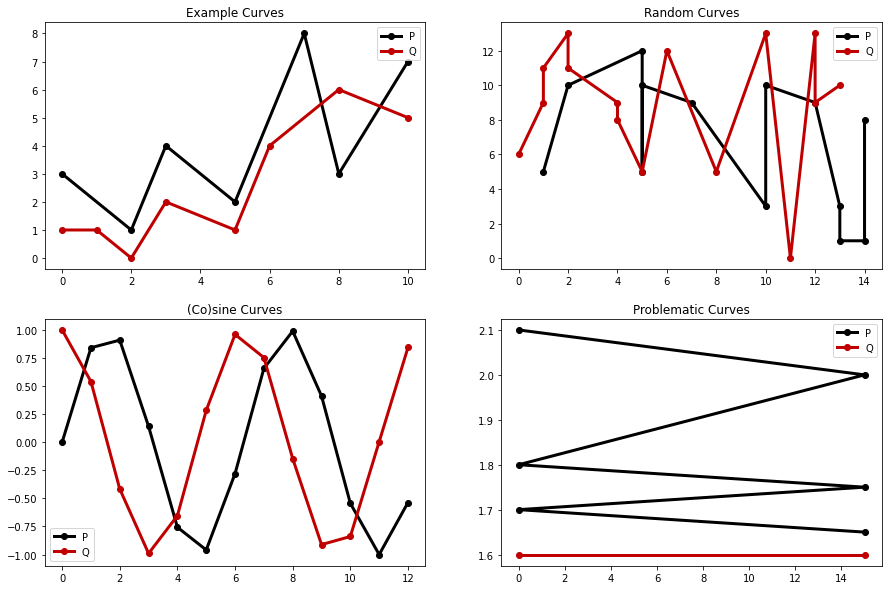

In [ ]:
# Example input
example_curves = [PolyCurve([(0, 3), (2, 1), (3,4), (5,2), (7,8), (8, 3), (10, 7)]), 
                  PolyCurve([(0, 1), (1, 1), (2, 0), (3,2), (5,1), (6, 4), (8, 6), (10, 5)])]

# Random curves
random_curves = [PolyCurve(zip(np.sort(np.random.randint(low=0, high=15, size=15)), np.random.randint(low=0, high=15, size=15))), 
                 PolyCurve(zip(np.sort(np.random.randint(low=0, high=15, size=15)), np.random.randint(low=0, high=15, size=15)))]

# Sine and cosine
co_sine_curves = [PolyCurve(zip(np.arange(0,4*np.pi,1), np.sin(np.arange(0,4*np.pi,1)))),
PolyCurve(zip(np.arange(0,4*np.pi,1), np.cos(np.arange(0,4*np.pi,1))))]

# Problematic input
problematic_curves = [PolyCurve([(0, 2.1), (15, 2), (0, 1.8), (15,1.75), (0, 1.7), (15, 1.65)]), 
                      PolyCurve([(0, 1.6), (15, 1.6)])]

fig, axs = plt.subplots(2, 2, figsize=(15,10))
plot_curves(example_curves[0], example_curves[1], axs[0, 0])
axs[0, 0].set_title('Example Curves')
plot_curves(random_curves[0], random_curves[1], axs[0, 1])
axs[0, 1].set_title('Random Curves')
plot_curves(co_sine_curves[0],  co_sine_curves[1], axs[1, 0])
axs[1, 0].set_title('(Co)sine Curves')
plot_curves(problematic_curves[0],  problematic_curves[1], axs[1, 1])
axs[1, 1].set_title('Problematic Curves')

fig.show()

The following cell determines which of the above demo curves is used for the rest of this notebook. Alternatively, you can define your own curves by overwriting variables `P` and `Q` at the end of the cell.

In [ ]:
# Choose one of: example_curves, random_curves, co_sine_curves, problematic_curves

P, Q = example_curves

# P = PolyCurve([(1, 1)])
# Q = PolyCurve([(1, 1)])

Let us first render an interactive plot for the selected demo curves. In particular, the two sliders for the markers on $P$ and $Q$ (the man and the dog) can be used to control their positions on their respective curve. In addition, the leash is visualized as a green line between the two markers and its length is displayed in the legend. The numbers on the right of the sliders indicate the total traversed distance from the start of the path until the marker.

In [ ]:
def plot_pq(Marker_P, Marker_Q):
  plot_curves(P, Q, markers=(Marker_P, Marker_Q))
plt.rcParams['figure.figsize'] = [9, 6]

# Code for interactivity
interactive_plot = interactive(plot_pq,
                               Marker_P=(0, P.parametric_distances[-1], 0.01),
                               Marker_Q=(0, Q.parametric_distances[-1], 0.01))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=12.35, description='Marker_P', max=24.714842698589884, step=0.01), Flo…

## Symbolic Computation
To avoid problems with robustness, we leverage symbolic computation. Symbolic computation relies on objects (or symbols) for calculating solutions or evaluating expressions. The main objects that we will use are Point, Segment and Circle. Symbolic computation allows us to avoid problems with robustness at the cost of a higher running time. For example, the answer to 3/9 would evaluate to 0.333333333, which precision is limited by the 64 bits of python's `float64`. A symbolic answer would be 1/3, or a representation thereof. The goal of this notebook is to educate, so practical performance is not the main goal. Hence, we use symbolic computation provided by the sympy library to run our algorithms exactly and avoid problems with robustness.

## Algorithms for the Fréchet distance
In this section we will present three approaches to solve Fréchet distance problems. First, we introduce a discrete variant, an approximation of the Fréchet distance which only considers the vertices of the curves. Secondly, we introduce a continuous variant which does include all points on the line segments of a curve. It presents an implementation for solving the decision problem together with an approximation for the Fréchet distance. Lastly, we address a weak variant of the Fréchet distance, where the man and dog are also allowed to move backwards. For this we will also introduce an algorithm to solve the decision problem as well as an algorithm to calculate the Fréchet distance exactly.

### Discrete Fréchet distance
An approximation for the Fréchet distance for polygonal curves was introduced by Eiter and Manilla [2]. Instead of considering all possible points on the curve, they present a discrete variation of the Fréchet distance, where only the vertices of the curves are considered. More formally, given two polygonal curves $P$ and $Q$, let $\sigma(P) = (u_1, \dots, u_p)$ and $\sigma(Q) = (v_1, \dots, v_q)$ be the sequence of endpoints of the line segments of $P$ and $Q$ respectively. A coupling $L$ between $P$ and $Q$ is then defined as a sequence $({u_a}_1, {v_b}_1), ({u_a}_2, {u_b}_2), \dots, ({u_a}_m, {v_b}_m)$ of distinct pairs from $\sigma(P) \times \sigma(Q)$ where $a_1 =1$, $b_1=1$, $a_m =p$, $b_m=q$, and for all $i \in  (1, \dots, q)$ we have $a_{i+1} = a_i$ or $a_{i+1}=a_i +1$, and $b_{i+1} = b_i$ or $b_{i+1}=b_i +1$. An example of such a coupling for two polygonal curves is given in the picture below, where the green lines indicate the distinct pairs from $\sigma(P) \times \sigma(Q)$.

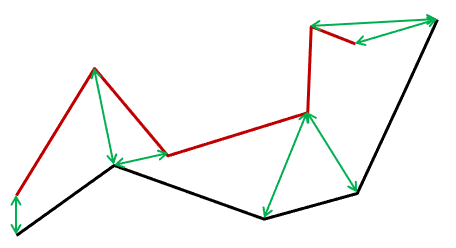

The length $\left\lVert L \right\rVert$ denotes the length of the longest link in the coupling $L$, and is given by:
$$
\begin{equation}
\left\lVert L \right\rVert = \max_{i=1,\dots, m} \left\lVert {u_a}_i - {v_b}_i \right\rVert
\end{equation}
$$
The *discrete* Fréchet distance $\delta_{dF}$ is then defined as:
$$
\begin{equation}
	\delta_{dF}(P, Q) = \min \big\{\left\lVert L \right\rVert \text{such that $L$ is a coupling between $P$ and $Q$}\big\}
\end{equation}
$$

Computing the discrete Fréchet distance can be done using a relatively simple dynamic programming algorithm that runs in $O(p \cdot q)$ time, where $p$ and $q$ are the number of vertices in curves $P$ and $Q$ respectively, without the need for complicated data structures. The cell below implements the algorithm as described by Eiter and Manilla using our PolyCurve data structure. The relative simplicity of the algorithm comes at the cost of an unbounded error on the approximation. Consider the following example, where the green coupling could be made arbitrarliy large, which in turn results in an arbitrarliy large error.

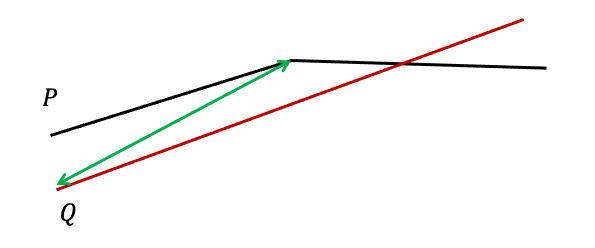

 #### Approximation of the Fréchet distance
 The following cell implements the `discrete_frechet` function and calculates the discrete Fréchet distance for two curves $P$ and $Q$.

In [ ]:
def discrete_frechet(P, Q):
    """
    Calculates the discrete frechet distance for two input PolyCurves
    """
    ca = (np.ones((len(P), len(Q)), dtype=np.float64) * -1)

    def dist(i, j):
        return P[i].distance(Q[j])

    def c(i, j):
        if ca[i, j] > - 1:
            return ca[i, j]
        elif i == 0 and j == 0:
            ca[i, j] = dist(i, j)
        elif i > 0 and j == 0:
            ca[i, j] = max(c(i - 1, 0), dist(i, j))
        elif i == 0 and j > 0:
            ca[i, j] = max(c(0, j - 1), dist(i, j))
        elif i > 0 and j > 0:
            ca[i, j] = max(min(c(i - 1, j), c(i - 1, j - 1), c(i, j - 1)), dist(i, j))
        else:
            ca[i, j] = np.Infinity
        return ca[i, j]

    return c(len(P) - 1, len(Q) - 1)

discrete_frechet(P, Q)

2.8284271247461903

### Continuous Fréchet distance

As opposed to the discrete Fréchet distance, the continuous Fréchet distance considers all possible points on the curve. Alt and Godau introduced an algorithm for computing the continuous Fréchet distance for polygonal curves [1]. The key concept of their algorithm is the free-space diagram, a two dimensional matrix with one curve projected on the $x$-axis and the other  curve projected on the $y$-axis. In essence, the free-space diagram shows for each combination of points on curves $P$ and $Q$ whether $\delta_F(P, Q) \leq \epsilon$, indicated by the free (white) space in the diagram. An example of such a free-space diagram is given below, where a curve $P$ is projected on the $x$-axis and a curve $Q$ on the $y$-axis.

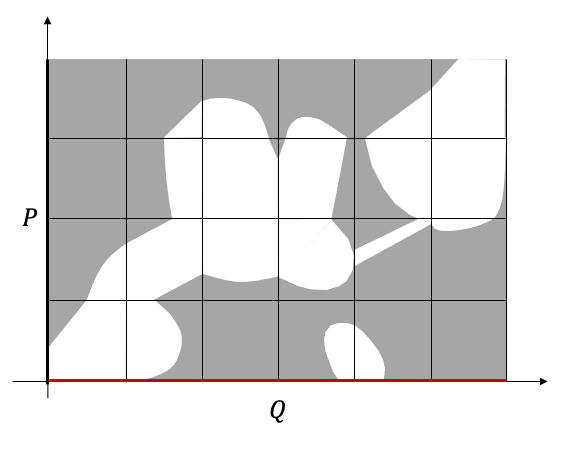

The free-space diagram of two curves $P$ and $Q$ has the following useful property: there exists a monotone (in both coordinates) path from the bottom-left to the top-right corner if and only if the Fréchet distance of $P$ and $Q$ is at most $\epsilon$. Such a monotone path could look as follows:

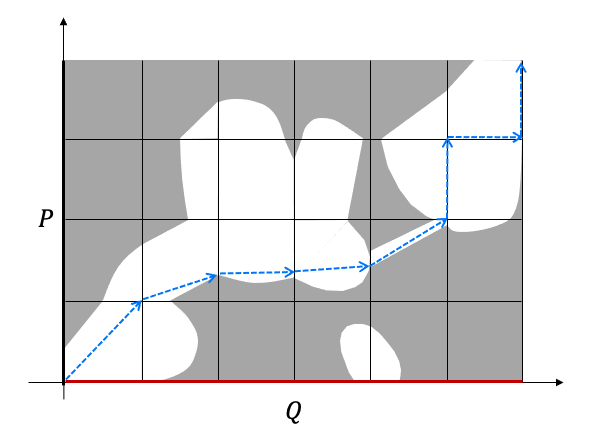

Hence, to determine whether a given leash of length $\epsilon$ is sufficient for curves $P$ and $Q$, it suffices to find a monotone path from the bottom-left to the top-right corner in the free-space diagram of $P$ and $Q$. The free-space diagram can be computed in $O(p \cdot q)$ time, where $p$ and $q$ denote the number of vertices in polygonal curve $P$ and $Q$. Similarly, a monotone path from the bottom-left to the top-right corner can also be computed in $O(p \cdot q)$ time. To see this, observe that all cells in the free-space diagram are rectangular and that the free space is an ellipsoid. This ellipsoid intersects in at most 8 points with the rectangular cell. Hence, to find a monotone path we check at most 8 points per cell, and there are $p \cdot q$ cells. It follows that we can compute the decision problem of the Fréchet distance, i.e.  $\delta_F(P, Q) \leq \epsilon$, in $O(p \cdot q)$ time.

The next cell implements a custom `FreeSpace` data structure that is created from two instances of `PolyCurve` $P$ and $Q$. This `FreeSpace` class will form the basis for the two algorithms using the free-space diagram to compute the decision problem, i.e. find a path from the bottom left to the upper right corner.

In [ ]:
class FreeSpace:
  def __init__(self, p, q):
    """
    :args
      p: The curve to be plotted on the x-axis of the freespace
      q: The curve to be plotted on the y-axis of the freespace
    """
    self.p = p
    self.q = q

  @property
  def len_p(self):
    """
    Computes the number of segments in p, whereas len(p) computes the number of 
    endpoints of the segments
    """
    return len(self.p) - 1

  @property
  def len_q(self):
    """
    Computes the number of segments in q, whereas len(q) computes the number of 
    endpoints of the segments
    """
    return len(self.q) - 1

  def compute_freespace(self):
    """
    Computes the numeric distances to a numpy array grid
    """
    x_d = self.p.parametric_distances[-1]
    xx = np.linspace(0, x_d, int(GRID_GRANULARITY * x_d))
    x = self.p.parametric(xx)

    y_d = self.q.parametric_distances[-1]
    yy = np.linspace(0, y_d, int(GRID_GRANULARITY * y_d))
    y = self.q.parametric(yy)

    distances = x.T[None, :, :] - y.T[:, None, :]
    return np.linalg.norm(distances, axis=2)

#### 2D Free-space
To showcase the free-space diagram of two curves $P$ and $Q$ we define the following two functions. The first function `plot_freespace` shows a similar interactive plot to the one seen before, but with the free-space diagram visualized next to it. The green point in the free-space diagram represents the projected leash. In specific, if the green point is within the "free" space (white), then the leash is long enough. Changing the slider values induces changes on both the line chart and the free-space diagram. Especially interesting is seeing how the amount of "free" space changes when the leash length $\epsilon$ is adjusted.

Additionally, the free-space diagram can be presented in 3D space, where the height ($z$-axis) of a point in the diagram represents the required leash length. The second function `plot_freespace_3d` creates an interactive 3D plot of the free-space of two curves.

In [ ]:
def plot_freespace(p, q, epsilon, ax=None, markers=None):
  if ax is None:
    m_fig, m_ax = plt.subplots(1)
  else:
    m_ax = ax

  m_ax.set_title('Freespace of Curves P and Q')

  m_ax.set_xlim([0, p.parametric_distances[-1] * GRID_GRANULARITY])
  m_ax.set_ylim([0, q.parametric_distances[-1] * GRID_GRANULARITY])

  space_grid = FreeSpace(p, q).compute_freespace()
  m_ax.imshow(space_grid <= epsilon, cmap=ListedColormap([COLOR_GRAY, 'white']), origin='lower', vmin=0, vmax=1)

  if markers is not None:
    marker_xy = (markers[0] * GRID_GRANULARITY, markers[1] * GRID_GRANULARITY)
    m_ax.scatter(*marker_xy, color=COLOR_GREEN)

  m_ax.grid(color='gray', linestyle='-', linewidth=1)

  x_ticks = p.parametric_distances[1:-1] * GRID_GRANULARITY
  m_ax.set_xticks(x_ticks);
  m_ax.set_xticklabels([round(t, 2) for t in x_ticks], rotation=45)

  y_ticks = q.parametric_distances[1:-1] * GRID_GRANULARITY
  m_ax.set_yticks(y_ticks);
  m_ax.set_yticklabels(round(t, 1) for t in y_ticks)

  m_ax.set_xlabel('Distance on curve P')
  m_ax.set_ylabel('Distance on curve Q')

  m_ax.xaxis.label.set_color(COLOR_BLACK)
  m_ax.yaxis.label.set_color(COLOR_RED)

  m_ax.spines['bottom'].set_color('Black')
  m_ax.spines['bottom'].set_linewidth(3)


  m_ax.spines['left'].set_color(COLOR_RED)
  m_ax.spines['left'].set_linewidth(3)


  if ax is None:
    m_fig.show()

def plot_freespace_3d(p, q):
  import plotly.graph_objects as go

  global GRID_GRANULARITY
  GRID_GRANULARITY_OLD = GRID_GRANULARITY
  GRID_GRANULARITY = 5

  space_grid = FreeSpace(p, q).compute_freespace()
  x_d = p.parametric_distances[-1]
  xx = np.linspace(0, x_d, int(GRID_GRANULARITY * x_d))

  y_d = q.parametric_distances[-1]
  yy = np.linspace(0, y_d, int(GRID_GRANULARITY * y_d))

  GRID_GRANULARITY = GRID_GRANULARITY_OLD


  c_min = np.min(space_grid)
  c_max = np.max(space_grid)
  c_size = c_max - c_min / 10

  camera = dict(
      up=dict(x=0, y=1, z=0),
      center=dict(x=0, y=0, z=0),
      eye=dict(x=0, y=0, z=3)
  )

  fig = go.Figure(data=[go.Surface(z=space_grid,
                                    x=xx,
                                    y=yy,
                                  contours = {
                                    "z": {"show": True, "start": c_min, "end": c_max, "size": 1}
                                      })])
  
  fig.update_layout(scene_camera=camera, title='3D plot of the FreeSpace', autosize=False,
                    width=1000, height=1000,
                    margin=dict(l=65, r=50, b=65, t=90),
                    )
  fig.show()

The following cell renders the 2D free-space.

In [ ]:
plt.rcParams['figure.figsize'] = [18, 5]

def plotfs_pq(epsilon, Marker_P, Marker_Q):
  fig, axs = plt.subplots(1, 2)
  plot_curves(P, Q, axs[0], (Marker_P, Marker_Q))
  plot_freespace(P, Q, epsilon, axs[1], (Marker_P, Marker_Q))
  fig.show()


# Code for interactivity
s = FreeSpace(P, Q).compute_freespace()
interactive_plot = interactive(plotfs_pq,
                               epsilon=(np.min(s), np.max(s)),
                               Marker_P=(0, P.parametric_distances[-1], 0.01),
                               Marker_Q=(0, Q.parametric_distances[-1], 0.01))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=5.832095799130232, description='epsilon', max=11.661903789690601, min=…

#### 3D Free-space
The free-space diagram shows exactly for which points on curves $P$ and $Q$ a given leash length $\epsilon$ is or is not long enough. However, no distinction is made between leash lengths inside either the free or non-free space. Interestingly, we can also plot the free-space diagram in 3D, where the third axis indicates the required leash length. The following cell renders an interactive 3D free-space diagram. You can use the mouse to change the perspective and see exactly what leash length $\epsilon$ is required for any two points on curves $P$ and $Q$.

In [ ]:
# 3D representation of the freespace. Note the contour lines matching the freespace above

plot_freespace_3d(P, Q)

In [ ]:
def freespace_distance(segment, point, epsilon):
  """
  Computes the distance from the first coordinate of the segment to the nearest
  point on the segment that can be reached given the epsilon (leash lenght)

  Returns:
    -1 if no point can be reached given the leash
    0 if the first point on the segment can be reached
    distance > 0 otherwise
  """  

  # Check if the segment can be reached for this epsilon
  distance = segment.distance(point)
  if distance > epsilon:
    return -1, -1

  # Slow method using sympy functions
  # critical_points = Circle(point, epsilon).intersect(segment)
  # critical_distances = [segment.points[0].distance(p) for p in critical_points]

  # Faster custom method
  critical_distances = fast_segment_circle_intersection(segment, Circle(point, epsilon))

  if len(critical_distances) == 0:
    return 0, np.inf

  dist_min = 0 if segment.points[0].distance(point) <= epsilon else max(critical_distances)
  dist_max = np.inf if segment.points[1].distance(point) <= epsilon else min(critical_distances)

  return dist_min, dist_max

def fast_segment_circle_intersection(segment, circle):
  # Use ray circle intersection. Code based on https://stackoverflow.com/questions/1073336/circle-line-segment-collision-detection-algorithm
  d = segment.points[1] - segment.points[0]
  f = segment.points[0] - circle.center

  a = _dot(d, d)
  b = 2*_dot(f, d)
  c = _dot(f, f) - circle.radius ** 2

  discriminant = b ** 2 - 4 * a * c

  if discriminant < 0:
    # No intersection
    return []

  if discriminant == 0:
    t1 = -b / (2 * a)
    return [segment.length * t1] if 0 <= t1 <= 1 else []

  discriminant = sympy.sqrt(discriminant)

  intersections = []
  t1 = (-b - discriminant)/(2*a);
  t2 = (-b + discriminant)/(2*a);

  if t1 >= 0 and t1 <= 1:
    intersections += [segment.length * t1]

  if t2 >= 0 and t2 <= 1:
    intersections += [segment.length * t2]

  return intersections

def _dot(p, q):
  return p.x * q.x + p.y * q.y 

#### Decision problem and approximation of the Fréchet distance

The paper by Alt and Godau presents an algorithm for calculating the continuous Fréchet distance [1]. This algorithm introduces the concept of critical values, values for $\epsilon$ for which a new passage opens between neighboring cells or a new horizontal or vertical passage opens within the diagram. Using the free-space diagram, one can calculate these critical values of $\epsilon$, sort them, and perform a exponential search with each step solving the decision problem. If the decision problem returns positive, continue with the half containing smaller critical values, and continue with the half containing larger critical values otherwise.

Unfortunately, calculating these critical values is rather involved, and due to time constraints we leave this for future work. Instead, we implement an approximation for the continuous problem in `approximate_minimum_distance` by performing a binary search on values of $\epsilon$ between a lower and upper bound directly. Similar to the original algorithm, we evaluate the decision problem for each value of $\epsilon$ and continue with the appropriate half. Additionally, we provide a parameter `tolerance` such that the error tolerance can be tweaked. Approximating the Fréchet distance with a small error is possible at the cost of a higher running time by setting the tolerance parameter sufficiently low.

The following cell extends the `FreeSpace` class defined above and includes functions for the decision problem and approximation of the Fréchet distance. The approximation is calculated by the function `approximate_minimum_distance`.

A simple check can be used to speed up computation in certain cases. Namely, if there is no free space in the bottom left or top right corner of the diagram, then by definition no path can exist between the bottom left and top right corner. Hence, we check if the start and endpoints can be reached at all and stop the algorithm prematurely if this is not the case. This functionality is provided by the `continuous_path_exists` function.

In [ ]:
class FreeSpaceContinuous(FreeSpace):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    
    # For visualisation purposes, 
    self.callback_continuous_explore = []

  def explore_continuous_freespace(self, epsilon):
    """
    Explores the freespace, checking if each cell can be reached in
    the strong Fréchet distance.
    
    :args
      visited: Array of cells that have already been explored
      x, y: The coordinates of the cell from which to explore further

    :returns
      True if the top rightmost cell in the freespace can be reached, else False
    """
    cell_entrance_coordinates = -np.ones((self.len_p, self.len_q, 2)) 
    cell_entrance_coordinates[0, 0, :] = np.zeros(2) 

    for x, y in it.product(range(self.len_p), range(self.len_q)):
      start_coords = cell_entrance_coordinates[x, y]

      # Optimization, only compute distances if we can reach this cell
      if all(start_coords < 0):
        continue

      dy, dy_max = freespace_distance(self.q.segments[y],
                                      self.p[x + 1],
                                      epsilon)
      dx, dx_max = freespace_distance(self.p.segments[x],
                                      self.q[y + 1],
                                      epsilon)
      # Check starting from left going up
      if start_coords[1] != -1 and dx >= 0 and y < self.len_q - 1:
        cell_entrance_coordinates[x, y + 1, 0] = dx
      # If this is not possible, go down to up
      elif start_coords[0] != -1 and dx >= 0 and y < self.len_q - 1 and start_coords[0] < dx_max:
        cell_entrance_coordinates[x, y + 1, 0] = max(start_coords[0], dx)
      
      # Check starting from down going right
      if start_coords[0] != -1 and dy >= 0 and x < self.len_p - 1:
        cell_entrance_coordinates[x + 1, y, 1] = dy
      # If this is not possible, go left to right
      elif start_coords[1] != -1 and dy >= 0 and x < self.len_p - 1 and start_coords[1] < dy_max:
        cell_entrance_coordinates[x + 1, y, 1] = max(start_coords[1], dy)

      self._callback_continuous(x, y, cell_entrance_coordinates)

    return cell_entrance_coordinates
              
  def _callback_continuous(self, x, y, cell_entrance_coordinates):
    for f in self.callback_continuous_explore:
      f(x, y, cell_entrance_coordinates.copy())

  def continuous_path_exists(self, epsilon):
    """
    Checks if a path exists between the start and the end of the freespace given
    'continuous' constraints
    """
    # Check if the start and end points can be reached
    if self.p[0].distance(self.q[0]) > epsilon or \
       self.p[-1].distance(self.q[-1]) > epsilon:
      return False

    return any(self.explore_continuous_freespace(epsilon)[-1, -1] >= 0)

  def find_continous_path(self, epsilon):
    if not self.continuous_path_exists(epsilon):
      return False

    cell_entrance_coordinates = self.explore_continuous_freespace(epsilon)

    p_distances = self.p.parametric_distances
    q_distances = self.q.parametric_distances

    # Define a polycurve in the continous space to find the path
    inversed_path = [(p_distances[-1], q_distances[-1])]
    x = self.len_p - 1
    y = self.len_q - 1
    
    while x != 0 or y != 0:
      if y > 0 and cell_entrance_coordinates[x, y, 0] >= 0:
        p = (p_distances[x] + cell_entrance_coordinates[x, y, 0], q_distances[y])
        inversed_path.append(p)
        y -=1
      elif x > 0 and cell_entrance_coordinates[x, y, 1] >= 0:
        p = (p_distances[x], q_distances[y] + cell_entrance_coordinates[x, y, 1])
        inversed_path.append(p)
        x -=1
      else:
        assert False, 'Something went wrong'
    path = inversed_path[::-1]
    path = [(0, 0)] + path
    return path

  def approximate_minimum_distance(self, tolerance=0.1, debug=False):

    # Exponential search step
    epsilon_max = 2
    epsilon_min = 0
    while not self.continuous_path_exists(epsilon_max):
      epsilon_min = epsilon_max
      epsilon_max *= epsilon_max
      if debug:
        print(f'exponential searching, range between {epsilon_min}, {epsilon_max}')

    while epsilon_max - epsilon_min > tolerance:
      if debug:
        print(f'binary searching, range between {epsilon_min}, {epsilon_max}')
      center = (epsilon_max + epsilon_min) / 2
      if self.continuous_path_exists(center):
        epsilon_max = center
      else:
        epsilon_min = center

    return epsilon_max

In [ ]:
FreeSpaceContinuous(P, Q).approximate_minimum_distance(debug=True)

exponential searching, range between 2, 4
binary searching, range between 2, 4
binary searching, range between 2, 3.0
binary searching, range between 2.5, 3.0
binary searching, range between 2.5, 2.75
binary searching, range between 2.5, 2.625


2.5625

#### Animation
The following cell animates the `find_continuous_path` algorithm above for a given $\epsilon$. The free-space diagram is shown on the left and the curves are plotted on the right.

In [ ]:
import plotly.express as px
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PatchCollection

%matplotlib inline

EPSILON = 5
N_FRAMES = 100

freespace = FreeSpaceContinuous(P, Q)

assert freespace.continuous_path_exists(EPSILON), 'Path does not exist'

plt.rcParams['figure.figsize'] = [18, 5]

fig, ax = plt.subplots(1, 2)

path = np.array(freespace.find_continous_path(EPSILON))

path_distances = np.cumsum(np.array([0] + [np.linalg.norm(x - y) for x, y in zip(path[1:], path[:-1])]))

point_on_path = interp1d(path_distances, path.T)(np.linspace(0, path_distances[-1], N_FRAMES))
plot_freespace(P, Q, EPSILON, ax[0])
plot_curves(P, Q, ax[1])

line_path, = ax[0].plot([], [], lw=2, color=COLOR_BLUE)
line_leash, = ax[1].plot([], [], lw=3, color=COLOR_GREEN)

def plot_leash(frame):
  cur = point_on_path[:, frame]

  px = P.parametric(cur[0])
  py = Q.parametric(cur[1])
  line_leash.set_data([px[0], py[0]], [px[1], py[1]])

  return line_leash

def plot_path(frame):
  cur = point_on_path[:, :frame] * GRID_GRANULARITY

  line_path.set_data(cur[0, :], cur[1, :]) 

  return line_path


def update(frame):
  return [plot_path(frame), plot_leash(frame)]

ani = FuncAnimation(fig, update, frames=np.arange(N_FRAMES), blit=True)
plt.close(fig)

from IPython.display import HTML
  
HTML(ani.to_html5_video())

This next cell renders the final path that was found for the free-space of curves $P$ and $Q$ and a given leash length $\epsilon$.

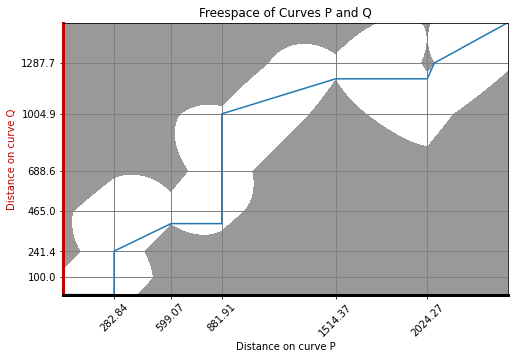

In [ ]:
EPSILON = 2.65

freespace = FreeSpaceContinuous(P, Q)


if not freespace.continuous_path_exists(EPSILON):
  plot_freespace(P, Q, EPSILON)
  print('Path does not exist')
else:
  fig, ax = plt.subplots(1)
  plot_freespace(P, Q, EPSILON, ax=ax)
  path = np.array(freespace.find_continous_path(EPSILON)) * GRID_GRANULARITY
  ax.plot(path[:, 0], path[:, 1])
  fig.show()

### Weak Fréchet distance
A variant of the continuous Fréchet distance is the weak Fréchet distance, which drops the requirement of monotonicity. In addition to controlling their speed, the man and the dog are also allowed to move backwards to keep the leash shorter. This can be especially impactful in certain problematic inputs such as curves $P$ and $Q$ below.

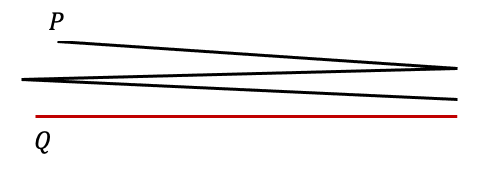

The free-space diagram has a similar relation with the weak Fréchet distance: there exists an arbitrary path from the bottom-left to the top-right corner if and only if the weak Fréchet distance of $P$ and $Q$ is at most $\epsilon$. Finding this path is done by starting the path in the bottom left corner and checking if it can reach each neighboring cell through the free space recursively. If the top right corner is reached then there must exist a path and we can conclude that the leash is long enough.

#### Decision problem and calculation of the Fréchet distance
The following cell extends the `FreeSpace` class defined earlier. This cell includes functions for determining the decision problem for the weak variant as well as an exact calculation of the weak Fréchet distance. The function `compute_minimum_distance` calculates the Fréchet distance for two curves $P$ and $Q$. Similar to the check in the continuous variant, we provide a way to reduce computation costs by checking if a path can exist at all by invoking `weak_path_exists`.

In [ ]:
class FreeSpaceWeak(FreeSpace):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    
    # For visualisation purposes, 
    self.callbacks_weak_explore = []

  def check_weak_transition(self, epsilon, x, y, dx, dy):
    """
    Checks if a transition can be made between two cells of the freespace for
    the weak variant of the Fréchet distance
    """
    assert -1 <= dx <= 1 and -1 <= dy <= 1 and abs(dx) + abs(dy) == 1, \
      'Only transitions to the horizontal or vertical neighbor can be made'

    if 0 <= x + dx < self.len_p and 0 <= y + dy < self.len_q:
      if dx != 0:
        return self.q.segments[y].distance(self.p[x + dx]) <= epsilon
      if dy != 0:
        return self.p.segments[x].distance(self.q[y + dy]) <= epsilon

    return False

  def explore_weak_freespace(self, epsilon, x=0, y=0, visited=None):
    """
    Explores the freespace, recursively checking if each cell can be reached in
    the weak Fréchet distance.
    
    :args
      visited: Array of cells that have already been explored
      x, y: The coordinates of the cell from which to explore further

    :returns
      True if the top rightmost cell in the freespace can be reached, else False
    """

    # Creates the 'closed list' of cells already visited if none are provided
    if visited is None:
      visited = np.zeros((self.len_p, self.len_q))

    if visited[x, y]:
      return False
    else:
      visited[x, y] = True

    # Provide callback for visualisation
    self._callback_weak(x, y, visited)

    # Return if the final cell is reached
    if x == self.len_p - 1 and y == self.len_q - 1:
      return True

    # Check if the neighboring cells can be reached, in the order:
    # right, top, left, bottom
    if self.check_weak_transition(epsilon, x, y, 1, 0) and self.explore_weak_freespace(epsilon, x + 1, y, visited):
        return True
    if self.check_weak_transition(epsilon, x, y, 0, 1) and self.explore_weak_freespace(epsilon, x, y + 1, visited):
        return True
    if self.check_weak_transition(epsilon, x, y, -1, 0) and self.explore_weak_freespace(epsilon, x - 1, y, visited):
        return True
    if self.check_weak_transition(epsilon, x, y, 0, -1) and self.explore_weak_freespace(epsilon, x, y - 1, visited):
        return True

    return False

  def _callback_weak(self, x, y, visited):
    for f in self.callbacks_weak_explore:
      f(x, y, visited.copy())

  def weak_path_exists(self, epsilon):
    """
    Checks if a path exists between the start and the end of the freespace given
    'weak' constraints
    """
    # Check if the start and end points can be reached
    if self.p[0].distance(self.q[0]) > epsilon or \
       self.p[-1].distance(self.q[-1]) > epsilon:
      return False

    return self.explore_weak_freespace(epsilon)

  def compute_minimum_distance(self, debug=False):
    critical_values = list()

    for x, y in it.product(range(self.len_p), range(self.len_q)):
      critical_values += [self.q.segments[y].distance(self.p.segments[x].points[0])]
      critical_values += [self.q.segments[y].distance(self.p.segments[x].points[1])]
      critical_values += [self.p.segments[x].distance(self.q.segments[y].points[0])]
      critical_values += [self.p.segments[x].distance(self.q.segments[y].points[1])]

    critical_values = sorted(list(set(critical_values)))

    i = 0
    while True:
      if debug:
        print(f'exp {i} of {len(critical_values)}')
      if self.weak_path_exists(critical_values[i]):
        break
      i = i**2 if i > 1 else i + 1
      if i > len(critical_values):
        i = len(critical_values)
        break

    if i == 0:
      return critical_values[i]
  
    min_range = int(np.log2(i))
    while i - min_range > 1:
      center = int((min_range + i) / 2)
      if debug:
        print(f'{i}, min range {min_range}, {critical_values[center]}, {self.weak_path_exists(critical_values[center])}')
      if self.weak_path_exists(critical_values[center]):
        i = center
      else:
        min_range = center

    return critical_values[i]

In [ ]:
print(f'The weak frechet distance is precisely: {FreeSpaceWeak(P, Q).compute_minimum_distance(True)}')

exp 0 of 47
exp 1 of 47
exp 2 of 47
exp 4 of 47
exp 16 of 47
16, min range 4, 9*sqrt(26)/26, False
16, min range 10, 3*sqrt(2)/2, False
16, min range 13, 7*sqrt(10)/10, False
16, min range 14, sqrt(5), True
The weak frechet distance is precisely: sqrt(5)


#### Animation
The next cell animates the `find_weak_path` algorithm above for a given $\epsilon$. The free-space diagram is shown on the left and the curves are plotted on the right. 

This animation does not explicitly show the constructed path, as can be found for the continuous variant. Instead, we opted to visualize how the algorithm computes the weak variant. The animation below shows which cells and in what order te algorithm is checking them. This is effectively a depth-first search (DFS), where the algorithm traverses the freespace recursively. The resulting output is if the algorithm can find a path from the bottom left cell to the top right cell. Within the algorithm itself there is no explicit computation for the path within the free-space that connects both of the cells. Explicit computation of the path can be avoided because the free-space between two line segments is always convex (ellipsoid).

In [ ]:
import plotly.express as px
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PatchCollection

%matplotlib inline

EPSILON = 2.65
weak_color_dict = {
    -1
}
plt.rcParams['figure.figsize'] = [9, 6]


freespace = FreeSpaceWeak(P, Q)
space_grid = freespace.compute_freespace()
weak_explore_cb = []
freespace.callbacks_weak_explore.append(lambda *args: weak_explore_cb.append(args))

def create_rect(x, y):
  x_rect = P.parametric_distances[x] * GRID_GRANULARITY
  y_rect = Q.parametric_distances[y] * GRID_GRANULARITY
  width = P.segments[x].length * GRID_GRANULARITY
  height = Q.segments[y].length * GRID_GRANULARITY

  return Rectangle((x_rect, y_rect), width, height, color=(0,0,1,0.5))

def update(frame):
  ax.set_title(str(weak_explore_cb[frame][:2]))
  ax.patches = []

  patches = []
  patches.append(create_rect(*weak_explore_cb[frame][:2]))
  for args in weak_explore_cb[:frame]:
    patches.append(create_rect(*args[:2]))
  for p in patches[1:]:
    p.set_color((0, 1, 0, 0.5))
  for p in patches:
    ax.add_patch(p)
  return []

if not freespace.weak_path_exists(EPSILON):
  print('The ends of the curves could not be reached for this value of Epsilon')

else:
  fig, ax = plt.subplots(1)
  plot_freespace(P, Q, EPSILON, ax)
    
  ani = FuncAnimation(fig, update, frames=range(len(weak_explore_cb)), blit=True)
  plt.close(fig)

  from IPython.display import HTML
  
HTML(ani.to_html5_video())

## Experimental Performance

It might be interesting to compare the performance of the algorithms for all our pairs of demo curves. The following cell measures the running time (in seconds) for each pair of demo curves for each of the implemented algorithms: discrete approximation, continuous decision, continuous approximation, weak decision and weak exact calculation.

In [ ]:
import time
import pandas as pd
from IPython.display import display, HTML

EPSILON = 5

def measure_elapsed(f, *args, **kwargs):
    t = time.process_time()
    f(*args, **kwargs)
    elapsed_time = time.process_time() - t
    return elapsed_time

def measure_execution_time(P, Q):
    return [measure_elapsed(discrete_frechet, P, Q),
            measure_elapsed(FreeSpaceContinuous(P, Q).continuous_path_exists, EPSILON),
            measure_elapsed(FreeSpaceContinuous(P, Q).approximate_minimum_distance),
            measure_elapsed(FreeSpaceWeak(P, Q).weak_path_exists, EPSILON),
            measure_elapsed(FreeSpaceWeak(P, Q).compute_minimum_distance)]

df = pd.DataFrame([], columns = ['discrete_approx', 'continuous_decision', 'continuous_approximation', 'weak_decision', 'weak_exact'])

for demo_curves in [[example_curves, 'example_curves'], [random_curves, 'random_curves'], [co_sine_curves, 'co_sine_curves'], [problematic_curves, 'problematic_curves']]:
    P, Q = demo_curves[0]
    values = measure_execution_time(P, Q)
    df.loc[demo_curves[1]] = measure_execution_time(P, Q)

display(HTML(df.to_html()))

,discrete_approx,continuous_decision,continuous_approximation,weak_decision,weak_exact
example_curves,0.031430,0.276701,1.230267,0.024966,0.761525
random_curves,0.121120,0.889085,6.777495,0.735022,5.756480
co_sine_curves,0.227472,2.220227,2.142058,0.104191,2.704520
problematic_curves,0.005773,0.030292,0.363380,0.015522,0.089747


Even though we used a small sample of demo curves, the results indicate that the type of curves can have a big impact on the practical running time. Some instances of random curves take upwards of 20 seconds to approximate the continuous Fréchet distance, while the 'example curves' need less than 2. We suspect this is because of the symbolic computation. In addition, the results show that decision problems are generally much faster to compute than approximations or exact calculations. As approximations or exact calculations generally rely on multiple instances of the decision problem, this is not surprising.



## Conclusion

This marks the end of the notebook. First, an overview of the Fréchet distance together with its definition was presented as an introduction to the topic. Subsequently, several approaches to address Fréchet problems were demonstrated together with their implementation. Furthermore, visualizations were made interactive where possible and animations were used to show the behavior of the algorithms. Moreover, symbolic computation provided by the sympy library was used to avoid problems with robustness. In summary, we hope this notebook was educational and can be further improved upon in the future.


## References

[1]	Alt, Helmut; Godau, Michael (1995), "Computing the Fréchet distance between two polygonal curves", International Journal of Computational Geometry and Applications, 5 (1–2): 75–91, doi:10.1142/S0218195995000064.

[2]	Eiter, Thomas; Mannila, Heikki (1994), Computing discrete Fréchet distance, Tech. Report CD-TR 94/64, Christian Doppler Laboratory for Expert Systems, TU Vienna, Austria.

[3]	Har-Peled, Sariel; Raichel, Benjamin (2014), The fréchet distance revisited and extended. ACM Trans. Algorithms 10, 1, Article 3 (January 2014), 22 pages.